# Antes de empezar:
- Lee el archivo README.md
- Comenta tanto como puedas y utiliza los recursos (archivo README.md)
- ¡Feliz aprendizaje!

In [39]:
# import numpy and pandas
import pandas as pd
import numpy as np
from scipy.stats import trim_mean, mode, skew, gaussian_kde, pearsonr, spearmanr, beta
from statsmodels.stats.weightstats import ztest as ztest

from scipy.stats import ttest_ind, norm, t
from scipy.stats import f_oneway
from scipy.stats import sem
from scipy import stats

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, norm, ks_2samp
import statsmodels.api as sm

# Reto 1 - Explorando los Datos

En este reto, examinaremos todos los salarios de los empleados de la Ciudad de Chicago. Comenzaremos cargando el conjunto de datos y examinando su contenido.

In [40]:
# Run this code:
salaries = pd.read_csv('./Current_Employee_Names__Salaries__and_Position_Titles.csv')

Examina el conjunto de datos `salaries` utilizando la función `head` que se muestra a continuación.

In [41]:
salaries.head()

,Name,Job Titles,Department,Full or Part-Time,Salary or Hourly,Typical Hours,Annual Salary,Hourly Rate
0,"AARON, JEFFERY M",SERGEANT,POLICE,F,Salary,NaN,101442.0,NaN
1,"AARON, KARINA",POLICE OFFICER (ASSIGNED AS DETECTIVE),POLICE,F,Salary,NaN,94122.0,NaN
2,"AARON, KIMBERLEI R",CHIEF CONTRACT EXPEDITER,GENERAL SERVICES,F,Salary,NaN,101592.0,NaN
3,"ABAD JR, VICENTE M",CIVIL ENGINEER IV,WATER MGMNT,F,Salary,NaN,110064.0,NaN
4,"ABASCAL, REECE E",TRAFFIC CONTROL AIDE-HOURLY,OEMC,P,Hourly,20.0,NaN,19.86


# Reto 2 - Pruebas de Hipótesis

En esta sección del laboratorio, vamos a probar si el salario por hora de todos los trabajadores por hora es significativamente diferente de $30/hora. Importa la función correcta para la prueba de una muestra desde scipy y realiza la prueba de hipótesis para un intervalo de confianza de dos lados del 95%.

In [42]:
# Initialize variables
contador = 0  # This will track the fraction of the dataset allocated to the test group
data = {}  # To store results

# Loop to calculate MDE for splits ranging from 5% to 50% of the dataset
while contador <= 0.45:
    contador += 0.05  # Increment the fraction for each iteration
    mde_list = []  # To store MDE values for each iteration
    avg_list = []  # To store average values for the control group
    
    # Perform 30 simulations for each split to average the MDE
    for i in range(1, 31):
        # Randomly split the dataset into test and control groups based on the current fraction
        test_df, control_df = train_test_split(salaries, test_size=contador)
        
        # Define the parameters for the MDE calculation
        alpha = 0.05  # Significance level
        beta = 0.8    # Desired statistical power
        
        # Calculate standard deviations for both groups
        std_dev_test = np.std(test_df['Annual Salary'])
        std_dev_control = np.std(control_df['Annual Salary'])
        
        # Calculate sample sizes
        sample_size_control = len(control_df)
        sample_size_test = len(test_df)
        
        # Calculate critical values for the two-tailed test
        z_alpha = norm.ppf(1 - alpha/2)
        z_beta = norm.ppf(beta)
        
        # Calculate pooled standard deviation
        pooled_std_dev = np.sqrt(((sample_size_control - 1) * std_dev_control**2 + 
                                  (sample_size_test - 1) * std_dev_test**2) / 
                                 (sample_size_control + sample_size_test - 2))
        
        # Calculate the MDE
        mde = (z_alpha + z_beta) * pooled_std_dev * np.sqrt(2 / sample_size_control)
        
        # Append the MDE and average control group price to their respective lists
        mde_list.append(mde)
        avg = np.mean(control_df['Annual Salary'])
        avg_list.append(avg)
    
    # Calculate and store the average MDE, average price, and MDE percentage for the current split
    data[(round(contador, 2))] = {'mde': round(np.mean(mde_list), 4),
                                  'avg': round(np.mean(avg_list), 4),
                                  'mde_%': round(np.mean(mde_list) / np.mean(avg_list) * 100, 2)}

In [43]:
print(data)

{0.05: {'mde': 2046.0614, 'avg': 86785.3151, 'mde_%': 2.36}, 0.1: {'mde': 1447.0106, 'avg': 86861.4934, 'mde_%': 1.67}, 0.15: {'mde': 1181.5255, 'avg': 86834.4337, 'mde_%': 1.36}, 0.2: {'mde': 1023.2762, 'avg': 86830.1124, 'mde_%': 1.18}, 0.25: {'mde': 915.2516, 'avg': 86817.2149, 'mde_%': 1.05}, 0.3: {'mde': 835.515, 'avg': 86783.1642, 'mde_%': 0.96}, 0.35: {'mde': 773.506, 'avg': 86816.2934, 'mde_%': 0.89}, 0.4: {'mde': 723.5604, 'avg': 86832.6853, 'mde_%': 0.83}, 0.45: {'mde': 682.1865, 'avg': 86765.9231, 'mde_%': 0.79}, 0.5: {'mde': 647.1844, 'avg': 86777.1499, 'mde_%': 0.75}}


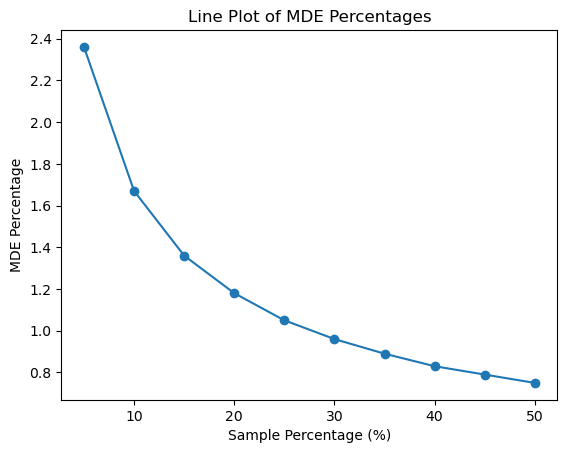

In [44]:
# Prepare data for plotting
percentage_split = [float(key)*100 for key in data.keys()]  # Convert keys to float and multiply by 100 to get percentages
mde_percentage_list_hist = [value['mde_%'] for value in data.values()]  # Extract MDE percentages

# Plotting
plt.plot(percentage_split, mde_percentage_list_hist, marker='o')  # 'o' adds markers to the line plot
plt.title('Line Plot of MDE Percentages')
plt.xlabel('Sample Percentage (%)')  # Updated to display counter percentage of the sample
plt.ylabel('MDE Percentage')

# Show the plot
plt.show()

In [45]:
test_df, control_df = train_test_split(salaries, test_size=0.3)

# Reto 3 - Construyendo Intervalos de Confianza

Aunque probar nuestra hipótesis es una excelente manera de obtener evidencia empírica para aceptar o rechazar la hipótesis, otra forma de recopilar evidencia es creando un intervalo de confianza. Un intervalo de confianza nos brinda información sobre la media verdadera de la población. Por lo tanto, para un intervalo de confianza del 95%, estamos seguros en un 95% de que la media de la población se encuentra dentro del intervalo de confianza.

Para leer más sobre los intervalos de confianza, haz clic [aquí](https://es.wikipedia.org/wiki/Intervalo_de_confianza).

En la celda a continuación, construiremos un intervalo de confianza del 95% para el salario por hora medio de todos los trabajadores por hora.

El intervalo de confianza se calcula en SciPy utilizando la función `t.interval`. Puedes leer más sobre esta función [aquí](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.t.html).

Para calcular el intervalo de confianza del salario por hora, usa 0.95 para el nivel de confianza, el número de filas - 1 para los grados de libertad, la media de la muestra para el parámetro de ubicación y el error estándar para la escala. El error estándar se puede calcular utilizando [esta](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.sem.html) función en SciPy.

In [47]:
mean_hourly_wage = np.mean(salaries['Annual Salary'])

# Calcular el error estándar de la media
sem_hourly_wage = stats.sem(salaries['Annual Salary'])

# Calcular el intervalo de confianza del 95%
confidence_interval = stats.t.interval(
    0.95,  # Nivel de confianza
    len(salaries['Annual Salary']) - 1,  # Grados de libertad
    loc=mean_hourly_wage,  # Media de la muestra
    scale=sem_hourly_wage  # Error estándar
)

print("Media de la muestra:", mean_hourly_wage)
print("Error estándar de la media:", sem_hourly_wage)
print("Intervalo de confianza del 95%:", confidence_interval)

Media de la muestra: 86786.99979015143
Error estándar de la media: nan
Intervalo de confianza del 95%: (nan, nan)


# Reto 4 - Pruebas de Hipótesis de Proporciones

Otro tipo de prueba de una muestra es una prueba de hipótesis de proporciones. En esta prueba, examinamos si la proporción de un grupo en nuestra muestra es significativamente diferente de una fracción.

Puedes leer más sobre las pruebas de proporción de una muestra [aquí](http://sphweb.bumc.bu.edu/otlt/MPH-Modules/BS/SAS/SAS6-CategoricalData/SAS6-CategoricalData2.html).

En la celda a continuación, utiliza la función `proportions_ztest` de `statsmodels` para realizar una prueba de hipótesis que determinará si el número de trabajadores por hora en la Ciudad de Chicago es significativamente diferente del 25% en el nivel de confianza del 95%.

In [ ]:
# Selecting the data from each DataFrame
data1 = control_df['Annual Salary']  # We select the column price from our df
data2 = test_df['Annual Salary']  # We select the column price from our df

# Perform the KS test
statistic, p_value = ks_2samp(data1, data2)

print(f"KS statistic: {statistic}")
print(f"P-value: {p_value}")

# Define the equivalence limits
low, upp = -0.5, 0.5 

# Unpacking the results
p_value_global, result_lower, result_upper = sm.stats.ttost_ind(data1, data2, low, upp)

# Print the results
print(f"Global p-value of TOST: {p_value_global}")
print(f"Inferiority test (difference > lower margin): Statistic = {result_lower[0]}, p-value = {result_lower[1]}")
print(f"Superiority test (difference < upper margin): Statistic = {result_upper[0]}, p-value = {result_upper[1]}")

# Interpretation based on p-values
if p_value_global < 0.05:
    print("There is enough statistical evidence to claim that the two group are equivalent within the specified equivalence margin.")
else:
    print("There is not enough evidence to claim that the two drugs are equivalent.")

# Perform the t-test
t_stat, p_value = ttest_ind(data1, data2)

# Print the results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("There is a significant difference between the two groups.")
else:
    print("There is no significant difference between the two groups.")

KS statistic: 0.008101152966894176
P-value: 0.7471129313966123
Global p-value of TOST: nan
Inferiority test (difference > lower margin): Statistic = nan, p-value = nan
Superiority test (difference < upper margin): Statistic = nan, p-value = nan
There is not enough evidence to claim that the two drugs are equivalent.
T-statistic: nan
P-value: nan
There is no significant difference between the two groups.
